# MNIST Handwritten digit classifier in browser

This notebook creates, train and export a model trained in MNIST handwritten digit classifying task, to be imported by tfjs in browser.


install `tensorflowjs`, which is only required in this notebook for saving the model compatible with `tensorflowjs`

In [2]:
!pip install tensorflowjs

    100% |████████████████████████████████| 81kB 7.5MB/s 
    100% |████████████████████████████████| 87.1MB 590kB/s 
    100% |████████████████████████████████| 13.9MB 4.0MB/s 
    100% |████████████████████████████████| 430kB 23.1MB/s 
    100% |████████████████████████████████| 61kB 27.2MB/s 
    100% |████████████████████████████████| 3.1MB 9.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
s3fs 0.2.1 has requirement six>=1.12.0, but you'll have six 1.11.0 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.16 which is incompatible.
google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is inc

Packages required for the notebook

In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras

print('tensorflow', tf.__version__)
print('tensorflowjs', tfjs.__version__)
print('keras', keras.__version__)

tensorflow 2.0.0-dev20190427
tensorflowjs 1.0.1
keras 2.2.4-tf


While this notebook was written the versions used were - 
```
tensorflow 2.0.0-dev20190412
tensorflowjs 1.0.1
keras 2.2.4-tf
```

### Constants

In [0]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1

NUM_EPOCHS = 5

## The model

Let's create the model

In [0]:
def get_model():
    model = keras.Sequential()
    
    # In the first layer of out convolutional neural network we have
    # to specify the input shape. Then we specify some paramaters for
    # the convolution operation that takes place in this layer.
    model.add(keras.layers.Conv2D(
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
        kernel_size=3,
        filters=32,
        strides=1,
        activation='relu',
        kernel_initializer='VarianceScaling'
    ))
    
    # The MaxPooling layer acts as a sort of downsampling using max values
    # in a region instead of averaging.
    model.add(keras.layers.MaxPool2D(
        pool_size=(2,2), 
        strides=(2,2)
    ))
    
    model.add(keras.layers.Dropout(0.2))
    
    # Repeat another Conv2D + MazPooling stack.
    # Note that we have more filters in the convolution.
    model.add(keras.layers.Conv2D(
        kernel_size=3,
        filters=64,
        strides=1,
        activation='relu',
        kernel_initializer='VarianceScaling'
    ))
    
    model.add(keras.layers.MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))
    
    model.add(keras.layers.Conv2D(
        kernel_size=3,
        filters=64,
        strides=1,
        activation='relu',
        kernel_initializer='VarianceScaling'
    ))
    
    model.add(keras.layers.Dropout(0.2))
    
    # Now we flatten the output from the 2D filters into a 1D vector to prepare
    # it for input into our last layer. This is common practice when feeding
    # higher dimensional data to a final classification output layer.
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(
        units=64,
        activation='relu',
        kernel_initializer='VarianceScaling',
        kernel_regularizer=keras.regularizers.l2(0.001)
    ))
    
    # Our last layer is a dense layer which has 10 output units, one for each
    # output class (i.e. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9).
    NUM_OUTPUT_CLASSES = 10;
    model.add(keras.layers.Dense(
        units=NUM_OUTPUT_CLASSES,
        activation='softmax',
        kernel_initializer='VarianceScaling',
        kernel_regularizer=keras.regularizers.l2(0.001)
    ))
    
    
    # Choose an optimizer, loss function and accuracy matric,
    # then compile and return the model
    optimizer = keras.optimizers.Adam();
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [0]:
?? keras.layers.Conv2D

## Train the model

### Model Selection

#### K-Fold

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

BATCH_SIZE = 64

NUM_TRAIN_SAMPLES = 60000
NUM_TEST_SAMPLES = 10000

K_FOLD = 3
NUM_VALIDATION_SAMPLES = NUM_TRAIN_SAMPLES // K_FOLD

train, test = mnist.load_data()

x_train, y_train = train
x_test, y_test = test

shuffled_indices = np.arange(x_train.shape[0])
np.random.shuffle(shuffled_indices)

x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_train = x_train.reshape((NUM_TRAIN_SAMPLES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((NUM_TEST_SAMPLES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x_test = x_test.astype('float32') / 255


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

validation_scores = []

for fold in range(K_FOLD):
  x_val = x_train[NUM_VALIDATION_SAMPLES * fold: NUM_VALIDATION_SAMPLES * (fold+1)]
  y_val = y_train[NUM_VALIDATION_SAMPLES * fold: NUM_VALIDATION_SAMPLES * (fold+1)]
  
  x_train_fld = np.concatenate((x_train[:NUM_VALIDATION_SAMPLES * fold], x_train[NUM_VALIDATION_SAMPLES * (fold+1):]))
  y_train_fld = np.concatenate((y_train[:NUM_VALIDATION_SAMPLES * fold], y_train[NUM_VALIDATION_SAMPLES * (fold+1):]))
  
  model = get_model()
  model.fit(
      x_train_fld,
      y_train_fld,
      batch_size=BATCH_SIZE,
      epochs=NUM_EPOCHS,
      shuffle=True,
      callbacks=None
  )
  scores = model.evaluate(x_val, y_val)
  validation_scores.append(scores)
  
np.average(validation_scores, axis=0)


    8192/11490434 [..............................] - ETA: 0s

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
40000/40000 [==============================] - 15s 381us/sample - loss: 3.4864 - accuracy: 0.2545
Epoch 2/5
40000/40000 [==============================] - 15s 384us/sample - loss: 1.4433 - accuracy: 0.5096
Epoch 3/5
40000/40000 [==============================] - 15s 383us/sample - loss: 0.5813 - accuracy: 0.8330
Epoch 4/5
40000/40000 [==============================] - 17s 430us/sample - loss: 0.4094 - accuracy: 0.8850
Epoch 5/5
20000/20000 [==============================] - 3s 138us/sample - loss: 0.2571 - accuracy: 0.9330
Epoch 1/5
40000/40000 [==============================] - 15s 385us/sample - loss: 3.1276 - accuracy: 0.3072
Epoch 2/5
40000/40000 [==============================] - 15s 385us/sample - loss: 0.8583 - accuracy: 0.7247
Epoch 3/5
40000/40000 [==============================] - 15s 381us/sample - loss: 0.4600 - accuracy: 0.8654
Epoch 4/5
40000/40000 [==============================] - 17s 434us/sampl

array([0.21627314, 0.94350002])

#### Epoch selection

In [21]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np

BATCH_SIZE = 64

NUM_TRAIN_SAMPLES = 60000
NUM_TEST_SAMPLES = 10000

NUM_VALIDATION_SAMPLES = NUM_TRAIN_SAMPLES * 10 // 100 # 10% of training samples

MAX_EPOCHS = 10

train, test = mnist.load_data()

x_train, y_train = train
x_test, y_test = test

shuffled_indices = np.arange(x_train.shape[0])
np.random.shuffle(shuffled_indices)

x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_train = x_train.reshape((NUM_TRAIN_SAMPLES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((NUM_TEST_SAMPLES, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x_test = x_test.astype('float32') / 255


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

validation_scores = []


x_val = x_train[:NUM_VALIDATION_SAMPLES]
y_val = y_train[:NUM_VALIDATION_SAMPLES]

x_train_ = x_train[NUM_VALIDATION_SAMPLES:]
y_train_ = y_train[NUM_VALIDATION_SAMPLES:]

model = get_model()
history = model.fit(
    x_train_,
    y_train_,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    shuffle=True,
    callbacks=None
)

  

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 40s 742us/sample - loss: 0.2666 - accuracy: 0.9339 - val_loss: 0.1131 - val_accuracy: 0.9790
Epoch 2/10
54000/54000 [==============================] - 41s 758us/sample - loss: 0.1110 - accuracy: 0.9790 - val_loss: 0.0775 - val_accuracy: 0.9858
Epoch 3/10
54000/54000 [==============================] - 41s 757us/sample - loss: 0.0896 - accuracy: 0.9832 - val_loss: 0.0738 - val_accuracy: 0.9873
Epoch 4/10
54000/54000 [==============================] - 40s 750us/sample - loss: 0.0757 - accuracy: 0.9860 - val_loss: 0.0612 - val_accuracy: 0.9902
Epoch 5/10
54000/54000 [==============================] - 39s 717us/sample - loss: 0.0689 - accuracy: 0.9874 - val_loss: 0.0659 - val_accuracy: 0.9882
Epoch 6/10
54000/54000 [==============================] - 40s 746us/sample - loss: 0.0625 - accuracy: 0.9883 - val_loss: 0.0594 - val_accuracy: 0.9887
Epoch 7/10
54000/54000 [=====================

In [0]:
model.save("cpt-5")

In [16]:
history_copy = history.history.copy()

history = model.fit(
    x_train_,
    y_train_,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    shuffle=True,
    callbacks=None
)



Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 41s 763us/sample - loss: 0.1405 - accuracy: 0.9835 - val_loss: 0.1409 - val_accuracy: 0.9832
Epoch 2/5
54000/54000 [==============================] - 39s 720us/sample - loss: 0.1407 - accuracy: 0.9840 - val_loss: 0.1426 - val_accuracy: 0.9828
Epoch 3/5
54000/54000 [==============================] - 42s 774us/sample - loss: 0.1389 - accuracy: 0.9837 - val_loss: 0.1341 - val_accuracy: 0.9857
Epoch 4/5
54000/54000 [==============================] - 38s 703us/sample - loss: 0.1375 - accuracy: 0.9839 - val_loss: 0.1327 - val_accuracy: 0.9860
Epoch 5/5
54000/54000 [==============================] - 40s 742us/sample - loss: 0.1368 - accuracy: 0.9844 - val_loss: 0.1363 - val_accuracy: 0.9858


Plot the epoch wise performance

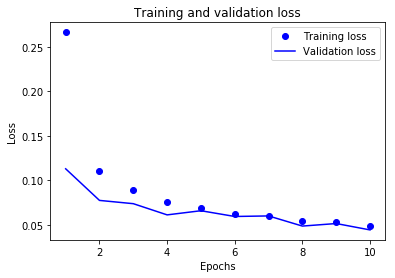

In [29]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Evaluate on test set

In [26]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 219us/sample - loss: 0.0433 - accuracy: 0.9929


[0.043273243573307994, 0.9929]

In [0]:
x_test.dtype

dtype('float32')

### Run the following code to authenticate/authorize your Google Drive for the purpose of mounting in this virtual machine
### we will use this to save the trained model to your GDrive

In [27]:
# Run this to authenticate/authorize your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Save the model

In [0]:
MODEL_SAVE_PATH_GDRIVE = '/content/gdrive/My Drive/mnist_cnn_tfjs'
tfjs.converters.save_keras_model(model, MODEL_SAVE_PATH_GDRIVE)

### The trained model is now available in your Google Drive in the location `My Drive/mnist_cnn_tfjs`